<a href="https://colab.research.google.com/github/ParsecInstitute/Astromatic2022/blob/main/Problems/P1_galaxy_photometry/p1_galaxy_morphology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification of galaxy morphology

### Problem description

The formation history of galaxies is not fully understood. There are many open questions: why do some galaxies have complex spiral arm structures while others are nearly featureless ellipsoids? What dynamical processes give rise to these structures? Why do star formation rates vary so much between galaxies?

In this problem, we will be taking a large set of real SDSS observations and training a neural network to classify the galaxies by their morphology while looking for outliers.
 
### What is the main issue?

Catalogs of extragalactic objects are growing rapidly, and with them, the amount of data we have as astronomers to sift through. One of the most basic, and most important, analysis tools is the classification of these objects. 

### What is the potential solution to this problem?

We can start by using a simple convolutional neural network to classify morphological images.

### What data will be used?

17,736 256x256 images from the [DESI Legacy Imaging Survey](https://www.legacysurvey.org/).

### Milestone estimators

- A **convolutional neural network** may be a good first step. You will need to decide on an appropriate metric to characterize its performance.
- **Pay attention to the data.** For example: how many examples are there for each morphology category? If the number differs between categories, what will you do about that? What about data augmentation or preprocessing?
- How could you detect **anomalies** in the dataset that don't fit well into any of the given categories?
- **Do you think the categories provided are a good way to classify morphology?** Can you come up with a different categorization direct from data using unsupervised learning?
- What other interesting tasks can you do with this dataset?

### Useful references:

- [Galaxy Zoo DECaLS: Detailed Visual Morphology Measurements from Volunteers and Deep Learning for 314,000 Galaxies](https://arxiv.org/abs/2102.08414)
- [GaMPEN: A Machine Learning Framework for Estimating Bayesian Posteriors of Galaxy Morphological Parameters](https://arxiv.org/abs/2207.05107)
- [Machine and Deep Learning Applied to Galaxy Morphology -- A Comparative Study](https://arxiv.org/abs/1901.07047)
- [Galaxy morphological classification in deep-wide surveys via unsupervised machine learning](https://arxiv.org/abs/1909.10537)
- [Galaxy morphology classification using automated machine learning](https://www.sciencedirect.com/science/article/abs/pii/S2213133721000469)
- [Machine Learning for Galaxy Morphology Classification](https://ui.adsabs.harvard.edu/abs/2010arXiv1005.0390G/abstract)
- [Machine learning technique for morphological classification of galaxies from the SDSS](https://www.aanda.org/articles/aa/full_html/2021/04/aa38981-20/aa38981-20.html)

## Setup

Creates a PyTorch dataset class to wrap the DECALs dataset. We use the version preprocessed by [astroNN](https://astronn.readthedocs.io/en/latest/index.html). The plot shows an example from the dataset. Note the colors are not the true observed colors -- the telescope uses the [g, r and z bands](https://en.wikipedia.org/wiki/Photometric_system).

In [ ]:
from typing import Dict

from google.colab import drive
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import trange


drive.mount('/content/drive')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
DATASET_PATH = "Galaxy10_DECals_shuffled.h5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy dataset to local storage to speed up IO
!rsync -av --progress --stats drive/MyDrive/Astromatic2022-Data/Problems/Problem1/Galaxy10_DECals_shuffled.h5 Galaxy10_DECals_shuffled.h5

sending incremental file list

Number of files: 1 (reg: 1)
Number of created files: 0
Number of deleted files: 0
Number of regular files transferred: 0
Total file size: 13,948,372,832 bytes
Total transferred file size: 0 bytes
Literal data: 0 bytes
Matched data: 0 bytes
File list size: 0
File list generation time: 0.002 seconds
File list transfer time: 0.000 seconds
Total bytes sent: 62
Total bytes received: 12

sent 62 bytes  received 12 bytes  148.00 bytes/sec
total size is 13,948,372,832  speedup is 188,491,524.76


In [ ]:
# class DECALSDatasetInRAM(Dataset):
#     """
#     A simple pytorch HDF5 dataset.
#     """
#     def __init__(self, path: str = DATASET_PATH):
#         self.path = path
#         self.file = h5py.File(path, "r")
#         self.morphology_names = {
#             0: "Disturbed Galaxies",
#             1: "Merging Galaxies",
#             2: "Round Smooth Galaxies",
#             3: "In-between Round Smooth Galaxies",
#             4: "Cigar Shaped Smooth Galaxies",
#             5: "Barred Spiral Galaxies",
#             6: "Unbarred Tight Spiral Galaxies",
#             7: "Unbarred Loose Spiral Galaxies",
#             8: "Edge-on Galaxies without Bulge",
#             9: "Edge-on Galaxies with Bulge"
#         }
#         self.num_morphologies = len(self.morphology_names)
#         self.data = torch.tensor(self.file["images"][:], dtype=torch.float32).moveaxis(-1, -3)
#         self.redshift = torch.tensor(self.file["redshift"][:], dtype=torch.float32)
#         self.morphology = torch.tensor(self.file["ans"][:], dtype=torch.int64)

#     def __getitem__(self, index) -> Dict[str, torch.Tensor]:
#         # Move channel from first to last axis
#         return {
#             "data": self.data[index],
#             "redshift": self.redshift[index],
#             "morphology": self.morphology[index]
#         }
    
#     def __len__(self) -> int:
#         return len(self.file["redshift"])

In [ ]:
class DECALSDatasetHDF5(Dataset):
    """
    A simple pytorch HDF5 dataset.
    """
    def __init__(self, path: str = DATASET_PATH):
        self.path = path
        # self.file = h5py.File(path, "r")
        self.morphology_names = {
            0: "Disturbed Galaxies",
            1: "Merging Galaxies",
            2: "Round Smooth Galaxies",
            3: "In-between Round Smooth Galaxies",
            4: "Cigar Shaped Smooth Galaxies",
            5: "Barred Spiral Galaxies",
            6: "Unbarred Tight Spiral Galaxies",
            7: "Unbarred Loose Spiral Galaxies",
            8: "Edge-on Galaxies without Bulge",
            9: "Edge-on Galaxies with Bulge"
        }
        self.num_morphologies = len(self.morphology_names)
        with h5py.File(self.path, "r") as file:
            self._len = len(file["images"])

    def __getitem__(self, index) -> Dict[str, torch.Tensor]:
        with h5py.File(self.path, "r") as file:
            # Move channel from first to last axis
            data = torch.tensor(file["images"][index], dtype=torch.float32).moveaxis(-1, -3)
            redshift = torch.tensor(file["redshift"][index], dtype=torch.float32)
            morphology = torch.tensor(file["ans"][index], dtype=torch.int64)

        return {"data": data, "redshift": redshift, "morphology": morphology}
    
    def __len__(self) -> int:
        return self._len  # len(self.file["redshift"])

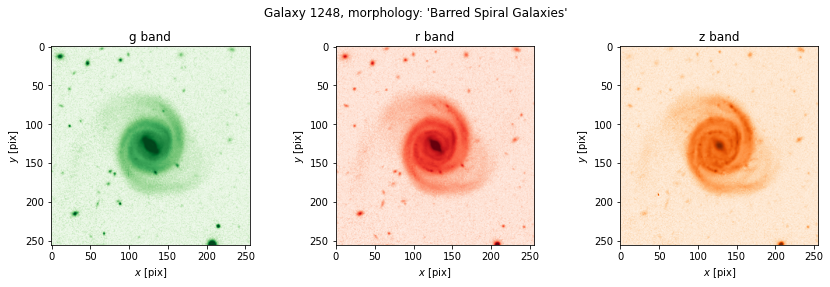

In [ ]:
# Plot an image from the dataset
dataset = DECALSDatasetHDF5()
idx = 1248
sample = dataset[idx]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

ax = axs[0]
ax.imshow(sample["data"][0], cmap="Greens")
ax.set_title("g band")
ax.set_xlabel(r"$x$ [pix]")
ax.set_ylabel(r"$y$ [pix]")

ax = axs[1]
ax.imshow(sample["data"][1], cmap="Reds")
ax.set_title("r band")
ax.set_xlabel(r"$x$ [pix]")
ax.set_ylabel(r"$y$ [pix]")

ax = axs[2]
ax.imshow(sample["data"][2], cmap="Oranges")
ax.set_title("z band")
ax.set_xlabel(r"$x$ [pix]")
ax.set_ylabel(r"$y$ [pix]")

fig.suptitle(
    f"Galaxy {idx}, morphology: '{dataset.morphology_names[sample['morphology'].item()]}'"
)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

## Inference

In [ ]:
# TODO: define network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, data):
        ...

In [ ]:
# Create network
network = Network()
network.to(DEVICE)  # move network to GPU

# # Initialize dataloader
dataset = DECALSDatasetHDF5()
# dataset = DECALSDatasetInRAM()

# Get dataset sizes and make train-val-test split
train_frac = 0.8
val_frac = 0.1
n_all = len(dataset)
n_train = int(train_frac * n_all)
n_val = int(val_frac * n_all)
n_test = n_all - n_train - n_val
ds_train, ds_val, ds_test = random_split(dataset, [n_train, n_val, n_test])

# Wrap in dataloaders
batch_size = 256  # feel free to change!
num_workers = 2  # set to 0, 1 or 2
dl_train = DataLoader(ds_train, batch_size, shuffle=True, num_workers=num_workers)
dl_val = DataLoader(ds_val, batch_size, shuffle=False, num_workers=num_workers)
dl_test = DataLoader(ds_test, batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
n_epochs = 1
losses = []
losses_val = []
for epoch in trange(n_epochs):
    # Train
    network.train()
    for b, batch in enumerate(dl_train):
        # Put batch on GPU
        # data = batch["data"].to(DEVICE)
        # morphology = batch["morphology"].to(DEVICE)
        # redshift = batch["redshift"].to(DEVICE)

        # Reset the optimizer
        # optimizer.zero_grad()

        # Predict!
        # morphology_pred = network(data)

        # Compute loss, backpropagate and take an optimization ste[p]
        # loss = loss_fn(y_pred, y)
        # loss.backward()
        # optimizer.step()

        # Save minibatch loss
        # losses.append(loss.item())

        print(f"loaded batch {b}")
        # break
    print("done training")
    
    # Validate
    network.eval()
    with torch.no_grad():
        for b, batch in enumerate(dl_val):
            # Put batch on GPU
            # data = batch["data"].to(DEVICE)
            # morphology = batch["morphology"].to(DEVICE)
            # redshift = batch["redshift"].to(DEVICE)
            # Predict and get loss
            # morphology_pred = network(data)
            # loss_val = loss_fn(y_pred, y)

            # Save minibatch loss
            # losses_val.append(loss_val.item())

            print(f"loaded batch {b}")
            # break
        print("done validating")

  0%|          | 0/1 [00:00<?, ?it/s]

loaded batch 0
loaded batch 1
loaded batch 2
loaded batch 3
loaded batch 4
loaded batch 5
loaded batch 6
loaded batch 7
loaded batch 8
loaded batch 9
loaded batch 10
loaded batch 11
loaded batch 12
loaded batch 13
loaded batch 14
loaded batch 15
loaded batch 16
loaded batch 17
loaded batch 18
loaded batch 19
loaded batch 20
loaded batch 21
loaded batch 22
loaded batch 23
loaded batch 24
loaded batch 25
loaded batch 26
loaded batch 27
loaded batch 28
loaded batch 29
loaded batch 30
loaded batch 31
loaded batch 32
loaded batch 33
loaded batch 34
loaded batch 35
loaded batch 36
loaded batch 37
loaded batch 38
loaded batch 39
loaded batch 40
loaded batch 41
loaded batch 42
loaded batch 43
loaded batch 44
loaded batch 45
loaded batch 46
loaded batch 47
loaded batch 48
loaded batch 49
loaded batch 50
loaded batch 51
loaded batch 52
loaded batch 53
loaded batch 54
loaded batch 55
done training
loaded batch 0
loaded batch 1
loaded batch 2
loaded batch 3
loaded batch 4
loaded batch 5
loaded bat